 ###### Jarque-Bera Test: 
 A goodness of fit test of whether sample data have the skewness and kurtosis of a normal distribution. The null hypothesis is that our distribution is normal. For a given p-value, lower values of our test statistic represent decreasing confidence in the rejection of the null, i.e. a greater degree of normality.

##### Augmented Dickey-Fuller Test: 
A frequentist test with the null hypothesis that some unit root is present in our data, indicating a lack of stationarity. The test statistic is negative, with a more negative result indicating a stronger rejection of our null hypothesis, i.e. less indication of stationarity.

##### Breusch-Pagan Test: 
A chi-squared test with the null hypothesis that homoskedasticity is exhibited by our data with respect to the given variable. Generally, high values of the test-statistic support a theory of homoskedasticity, which is ideal in financial data, showing that our returns' variance is more constant with respect to time.

In [1]:
from scipy.stats import norm, t, jarque_bera
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.stats.diagnostic import het_breushpagan as bp
from statsmodels.tsa.stattools import acf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def import_data(fields):#importing Btc 1 hour data 
    df = pd.read_csv('BTCUSDT1MIN.csv', na_filter = True, parse_dates = True,index_col = 'Open time', usecols = ['Open time','Open','Close','High','Low', 'Volume' ])
    return df

In [3]:
prices = import_data(fields=['Open time','Open', 'High', 'Low', 'Close', 'Volume'])

In [4]:
prices.head()# test to make sure you have correct Data

,Open,High,Low,Close,Volume
Open time,,,,,
2018-08-06 00:07:00,7033.76,7036.95,7033.76,7034.22,32.547087
2018-08-06 00:08:00,7033.96,7038.00,7033.95,7037.99,33.140462
2018-08-06 00:09:00,7037.99,7050.20,7034.37,7048.15,45.396803
2018-08-06 00:10:00,7048.15,7050.39,7043.19,7045.01,34.852209
2018-08-06 00:11:00,7047.05,7052.00,7042.96,7047.45,16.652999


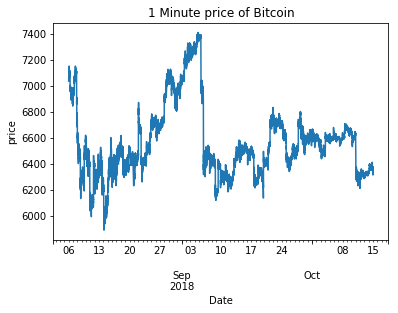

In [5]:
prices['Close'].plot()
plt.title('1 Minute price of Bitcoin');plt.xlabel('Date');plt.ylabel('price');

highest return:  0.015978581160292826
lowest return:  -0.01484994200848433


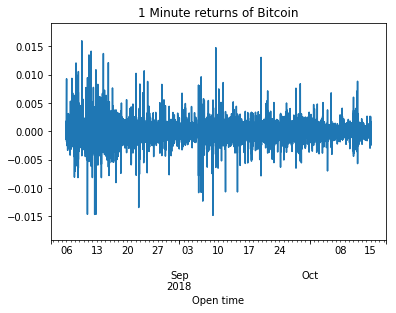

In [6]:
returns = prices['Close'].pct_change().dropna() #hourly retrun
returns.plot() 
plt.ylim(-0.0192, 0.0192)# standardize price
plt.title('1 Minute returns of Bitcoin' )
print('highest return: ', returns.max())
print('lowest return: ', returns.min())

C:\Users\chris\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Sample size 100801
Mean:  -7.438899791707809e-07
Variance 0.0007730251906914454
Jarque-Bera Test Results (5235809.126263949, 0.0)
Augmented Dickey-Fuller Test Results (-226.18740290039477, 0.0)


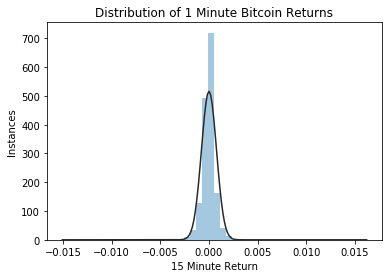

In [7]:
ax = sns.distplot(returns, fit=norm, kde=False)
plt.title('Distribution of 1 Minute Bitcoin Returns')
plt.xlabel('15 Minute Return')
plt.ylabel('Instances'); 

print('Sample size', len(returns))
print('Mean: ', returns.mean())
print('Variance', returns.std())
print('Jarque-Bera Test Results', jarque_bera(returns))
print('Augmented Dickey-Fuller Test Results', adf(returns, maxlag=1)[0:2])


In [8]:
# Since our base data are not ticks, we cannot infer our variables [OHLCV] if a bar is split
# So the target volume to set a bar is set to the maximum value on our interval,
# Each volume bar consists of at least 1 full time bar. This causes some volume inequity between bars, best I can do
tgt_volume=prices['Volume'].max()

# Indices in time bars where volume bars should end
bar_ends  = []
bar_volume = 0
skip = False # Ugly variable, used to skip an index in the loop if the 2nd volume is used

# Iterates over each pair of neighboring minute bars' volumes, selects the option that minimizes
for index, (volume1, volume2) in enumerate(zip(prices['Volume'], prices['Volume'][1:])):
    # Skips this iteration if the index was used already
    if (skip == True):
        skip = False
        continue
  
        # Includes 2nd index, set the loop to skip the next ireration 
    if (bar_volume + volume1 + volume2 > tgt_volume):
        d1 = abs(tgt_volume - (bar_volume + volume1))
        d2 = abs(tgt_volume - (bar_volume + volume1 + volume2))
        
        if (d1 > d2):
            bar_ends.append(index + 1)
            bar_volume = 0
            skip = True
            
        #Excludes the 2nd index, business as usual
        else: 
            bar_volume = 0 
    #if the pair wouldnt result in cross of the target, just add volume to teh first index
    else:
        bar_volume += volume1

# Transfers and combines information from time bars into volume bars
volume_bars = prices.iloc[bar_ends]
bar_count  = 0
bar_volume = 0
min_price  = prices.iloc[0]['Low']
max_price  = prices.iloc[0]['High']
open_price = prices.iloc[0]['Open']
close_price= prices.iloc[0]['Close']
for timestamp in prices.index:
    bar_volume += prices.loc[timestamp]['Volume']
    min_price = min(min_price, prices.loc[timestamp]['Low'])
    max_price = max(max_price, prices.loc[timestamp]['High'])
    
    if timestamp in volume_bars.index:
        volume_bars.loc[timestamp]['Open'] = open_price
        volume_bars.loc[timestamp]['High']       = max_price
        volume_bars.loc[timestamp]['Low']        = min_price
        close_price = prices.loc[timestamp]['Close']
        volume_bars.loc[timestamp]['Close']= close_price
        volume_bars.loc[timestamp]['Volume']     = bar_volume
        
        bar_volume  = 0
        bar_count  += 1
        if bar_count < len(volume_bars):
            open_price  = prices.loc[volume_bars.iloc[bar_count].name]['Open']

In [9]:
'''def volume_bars_vectorized(ohlcv, volume_threshold):
    #create 'volume-base' activity ohlcv bars 
    ohlcv = pd.DataFrame(prices)
    volume_threshold = ohlcv['Volume']  #This line need to be corrected to run properly ;-;
    cum_vol = ohlcv['Volume'].cumsum()
    grouper = cum_vol // volume_threshold
    
    # makes sure last minute bar is included in aggregation
    mask = grouper != grouper.shift(1)
    mask[0] = False
    grouper = (grouper - mask.astype(int)).values
    
    volume_ohlcv = (ohlcv.reset_index().groupby(grouper)
                    .agg({'Open': 'first', 'High': 'max', 
                          'Low': 'min', 'Close': 'last', 
                          'Volume': 'sum', 'Open time': 'last'})).set_index('Open time')
    volume_ohlcv=volume_ohlcv[['Open', 'High', 'Low', 'Close', 'Volume']]
    volume_ohlcv.index.name=None
    return volume_ohlcv

prices.groupby(prices.index.date)['Volume'].sum().mean(), tgt_volume
volume_bars_ = volume_bars_vectorized(prices,tgt_volume)
   '''                 


"def volume_bars_vectorized(ohlcv, volume_threshold):\n    #create 'volume-base' activity ohlcv bars \n    ohlcv = pd.DataFrame(prices)\n    volume_threshold = ohlcv['Volume']  #number of shares traded per bar\n    cum_vol = ohlcv['Volume'].cumsum()\n    grouper = cum_vol // volume_threshold\n    \n    # makes sure last minute bar is included in aggregation\n    mask = grouper != grouper.shift(1)\n    mask[0] = False\n    grouper = (grouper - mask.astype(int)).values\n    \n    volume_ohlcv = (ohlcv.reset_index().groupby(grouper)\n                    .agg({'Open': 'first', 'High': 'max', \n                          'Low': 'min', 'Close': 'last', \n                          'Volume': 'sum', 'Open time': 'last'})).set_index('Open time')\n    volume_ohlcv=volume_ohlcv[['Open', 'High', 'Low', 'Close', 'Volume']]\n    volume_ohlcv.index.name=None\n    return volume_ohlcv\n\nprices.groupby(prices.index.date)['Volume'].sum().mean(), tgt_volume\nvolume_bars_ = volume_bars_vectorized(prices,tgt

Text(0,0.5,'Price')

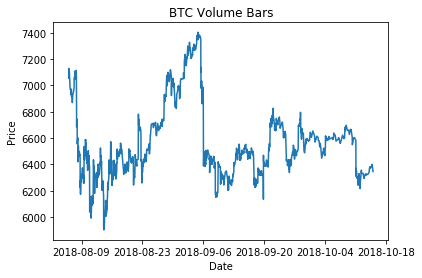

In [10]:
plt.plot(volume_bars['Close'])
plt.title('BTC Volume Bars')
plt.xlabel('Date')
plt.ylabel('Price')

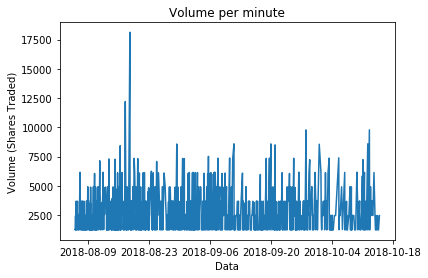

In [34]:
plt.plot(volume_bars['Volume'])
plt.title('Volume per minute' )
plt.xlabel('Data')
plt.ylabel('Volume (Shares Traded)');

In [12]:
print('Target Volume: ', tgt_volume)
print('Mean Volume: ', volume_bars['Volume'].mean())
print('Max Volume Multiple: ', volume_bars['Volume'].max()/tgt_volume)
print('Min Volume Multiple: ', volume_bars['Volume'].min()/tgt_volume)
print('# Under: ', len(volume_bars[volume_bars['Volume'] < tgt_volume]))
print('# Over : ', len(volume_bars[volume_bars['Volume'] > tgt_volume]))


Target Volume:  1232.878849
Mean Volume:  2475.678326169968
Max Volume Multiple:  14.702229652736948
Min Volume Multiple:  1.0000638619115445
# Under:  0
# Over :  1059


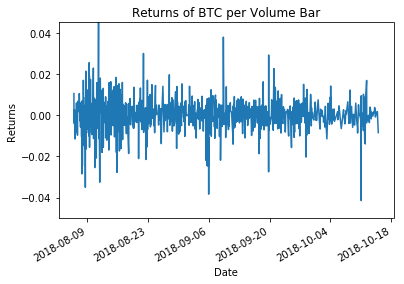

In [21]:
returns = volume_bars['Close'].pct_change().dropna() #Returns per bar
returns.plot()
plt.ylim(-0.05, 0.045)
plt.title('Returns of BTC per Volume Bar');  plt.xlabel('Date'); plt.ylabel('Returns');

##### As we can see variance is changing over time
##### This could be problematic for our stationarity test(Dickey- Fuller test) as it ehibits  'abnormal variance'

C:\Users\chris\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Sample size:  1058
Mean:  -7.273652302783281e-05
Variance:  0.007422321819084646
Jarque-Bera Test Results (1972.382725969416, 0.0)
Augmented Dickey-Fuller Test Results (-34.29617221864614, 0.0)


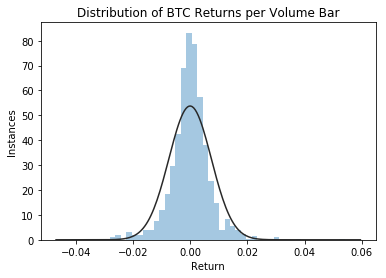

In [31]:
ax = sns.distplot(returns, fit=norm, kde = False)
plt.title('Distribution of BTC Returns per Volume Bar')
plt.xlabel('Return')
plt.ylabel('Instances');
print('Sample size: ', len(returns))
print('Mean: ', returns.mean())
print('Variance: ', returns.std())
print('Jarque-Bera Test Results', jarque_bera(returns))
print('Augmented Dickey-Fuller Test Results', adf(returns, maxlag=1)[0:2])

In [15]:
#replaces volume column vith calue volumn
dollar_bars = prices
mean_price_est = (dollar_bars['High'] + dollar_bars['Low'])/ 2
tgt_value   = (dollar_bars['Volume'] * mean_price_est).dropna().max()
dollar_bars['value'] = dollar_bars['Volume'] * mean_price_est 
dollar_bars.drop('Volume', axis=1)

# same optimazation methpd as in volume bars 
bar_ends = []
bar_value = 0 
skip = False 
for index, (value1, value2) in enumerate(zip(dollar_bars['value'], dollar_bars['value'][1:])):
    if (skip == True):
        bar_value = 0 
        skip = False
        continue
    
    if (bar_value + value1 +value2 > tgt_value):
        d1 = abs(tgt_value - (bar_value + value1))
        d2 = abs(tgt_value - (bar_value + value1 + value2))
        if (d1 > d2):
            bar_ends.append(index + 1)
            bar_value = 0
            skip = True
        else:
            bar_ends.append(index)
            bar_value = 0    
    else:
        bar_value += value1
        
dollar_bar = prices.iloc[bar_ends]
bar_count = 0 
bar_value = 0 
min_price = prices.iloc[0]['Low']
max_price = prices.iloc[0]['High']
open_price = prices.iloc[0]['Open']
close_price = prices.iloc[0]['Close']

for timestamp in prices.index:
    volume = prices.loc[timestamp]['Volume']
    mean_price_est = (prices.loc[timestamp]['High'] + prices.loc[timestamp]['Low']) / 2
    bar_value += volume * mean_price_est
    min_price = min(min_price, prices.loc[timestamp]['Low'])
    max_price = max(max_price, prices.loc[timestamp]['High'])
    
    if timestamp in dollar_bars.index:
        dollar_bars.loc[timestamp]['Open'] = open_price
        dollar_bars.loc[timestamp]['High']           = max_price
        dollar_bars.loc[timestamp]['Low']            = min_price
        close_price = prices.loc[timestamp]['Close']
        dollar_bars.loc[timestamp]['Close']    = close_price
        dollar_bars.loc[timestamp]['value']          = bar_value
        
        bar_value  = 0
        bar_count  += 1
        if bar_count < len(dollar_bars):
            open_price  = prices.loc[dollar_bars.iloc[bar_count].name]['Open']



Text(0,0.5,'Price')

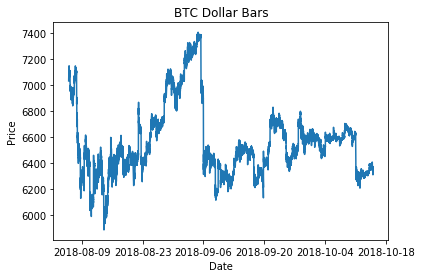

In [16]:
plt.plot(dollar_bars['Close'])
plt.title('BTC Dollar Bars'); plt.xlabel('Date'); plt.ylabel('Price')

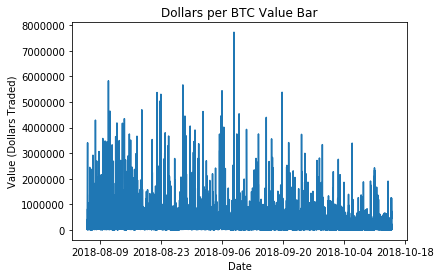

In [17]:
plt.plot(dollar_bars['value'])
plt.title('Dollars per BTC Value Bar'); plt.xlabel('Date'); plt.ylabel('Value (Dollars Traded)');

In [18]:
print('Target Value: ', tgt_value)
print('Mean Value: ', dollar_bars['value'].mean())
print('Max Value Multiple: ', dollar_bars['value'].max()/tgt_value)
print('Min Value Multiple: ', dollar_bars['value'].min()/tgt_value)
print('# Under: ', len(dollar_bars[dollar_bars['value'] < tgt_value]))
print('# Over : ', len(dollar_bars[dollar_bars['value'] > tgt_value]))

Target Value:  7723788.72836916
Mean Value:  170681.81631238788
Max Value Multiple:  1.0
Min Value Multiple:  9.28879735297324e-06
# Under:  100801
# Over :  0


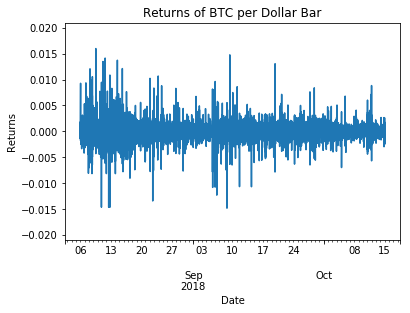

In [19]:
returns = dollar_bars['Close'].pct_change().dropna() #Returns per bar
returns.plot()
plt.ylim(-0.021, 0.021)
plt.title('Returns of BTC per Dollar Bar')
plt.xlabel('Date')
plt.ylabel('Returns');

C:\Users\chris\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Sample size:  1058
Mean:  -7.273652302783281e-05
Variance:  0.007422321819084646
Jarque-Bera Test Results (1972.382725969416, 0.0)
Augmented Dickey-Fuller Test Results (-34.29617221864614, 0.0)


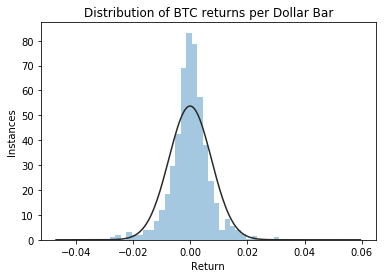

In [23]:
# Histogram + distribution of returns
ax = sns.distplot(returns, fit=norm, kde=False)
plt.title('Distribution of BTC returns per Dollar Bar')
plt.xlabel('Return')
plt.ylabel('Instances');

print('Sample size: ', len(returns))
print('Mean: ', returns.mean())
print('Variance: ', returns.std())
print('Jarque-Bera Test Results', jarque_bera(returns))
print('Augmented Dickey-Fuller Test Results', adf(returns, maxlag=1)[0:2])